<a href="https://colab.research.google.com/github/nabila-nazzy/Kmeans/blob/main/DMV302_KMEANS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-MEANS Algorithm
> Details etc here at the end

> **Importing the CSV file**.
This csv file contains 2 columns and 1000 rows in the dataset.

In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving DMV302_Assessment_2_HouseholdWealth.csv to DMV302_Assessment_2_HouseholdWealth (3).csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import io
 
df = pd.read_csv(io.BytesIO(uploaded['DMV302_Assessment_2_HouseholdWealth.csv']))
print(df)

     household_total_assets  annual_household_income
0                   1230531                    15724
1                   4877446                   124751
2                   4430878                   124372
3                   1954751                   179311
4                   2179963                    56355
..                      ...                      ...
995                 4006949                   253042
996                 3816007                    32384
997                  985874                   196997
998                  482927                    35603
999                   30641                    93254

[1000 rows x 2 columns]


In [ ]:
data = df.loc[:, ['household_total_assets', 'annual_household_income']]
data.head()

,household_total_assets,annual_household_income
0,1230531,15724
1,4877446,124751
2,4430878,124372
3,1954751,179311
4,2179963,56355


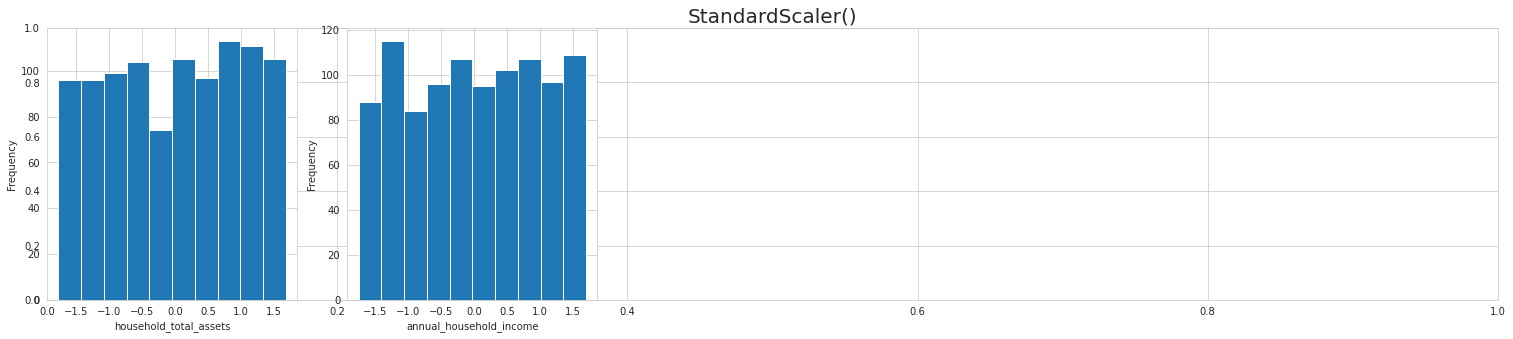

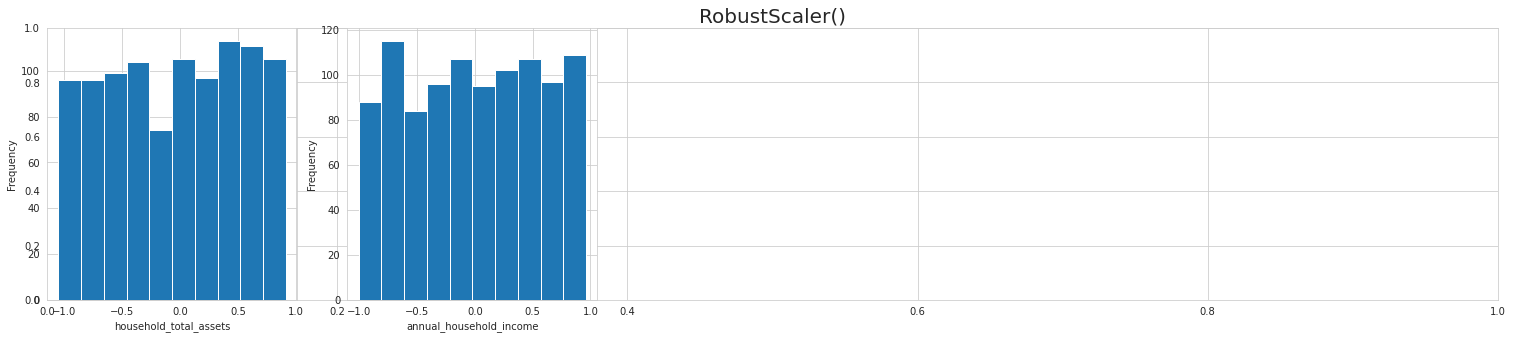

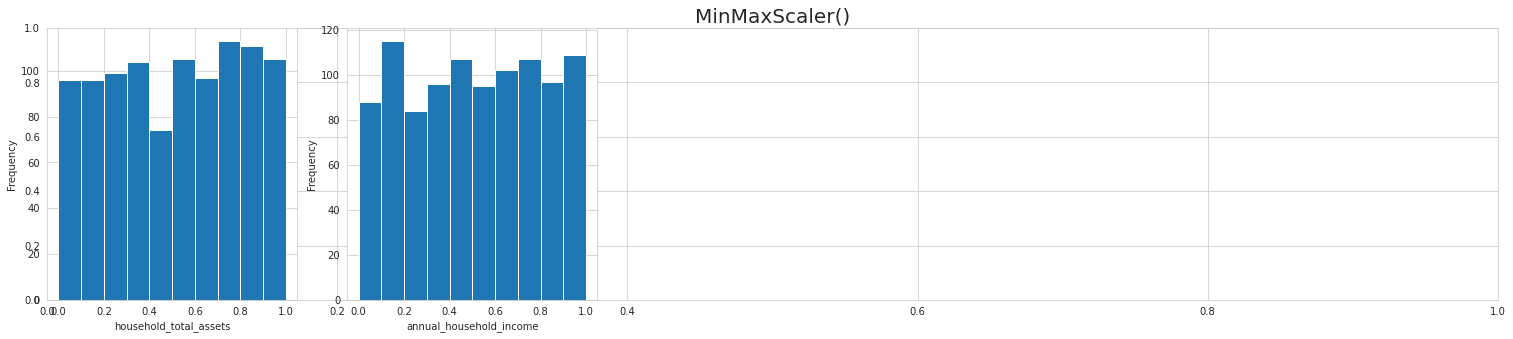

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scale_var = ['household_total_assets', 'annual_household_income']
scalers_list = [StandardScaler(), RobustScaler(), MinMaxScaler()]

for i in range(len(scalers_list)):
    scaler = scalers_list[i]
    fig = plt.figure(figsize = (26, 5))
    plt.title(scaler, fontsize = 20)
    for j in range(len(scale_var)):
        var = scale_var[j]
        scaled_var = "scaled_" + var
        model = scaler.fit(df[var].values.reshape(-1,1))
        df[scaled_var] = model.transform(df[var].values.reshape(-1, 1))

        sub = fig.add_subplot(1, 5, j + 1)
        sub.set_xlabel(var)
        df[scaled_var].plot(kind = 'hist')

simply transforming the data with these libraries, the kmeans model is made from numpy.

In [ ]:
print(df[scaled_var])

0      0.052374
1      0.416263
2      0.414998
3      0.598363
4      0.187984
         ...   
995    0.844448
996    0.107978
997    0.657391
998    0.118722
999    0.311138
Name: scaled_annual_household_income, Length: 1000, dtype: float64


In [ ]:
data = df.loc[:, ['scaled_household_total_assets', 'scaled_annual_household_income']]
data.head()

,scaled_household_total_assets,scaled_annual_household_income
0,0.246480,0.052374
1,0.977728,0.416263
2,0.888186,0.414998
3,0.391694,0.598363
4,0.436852,0.187984


In [ ]:
X = data.values

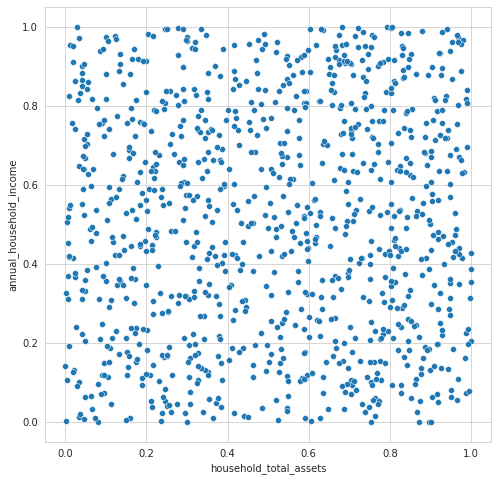

In [ ]:
sns.scatterplot(X[:,0], X[:, 1])
plt.xlabel("household_total_assets")
plt.ylabel("annual_household_income")
plt.show()

Calculating the **WCSS**

In [ ]:
def calculate_cost(X, centroids, cluster):

    sum = 0

    for i, val in enumerate(X):

      sum += np.sqrt((centroids[int(cluster[i]), 0]-val[0])**2 + (centroids[int(cluster[i]), 1])-val[1]**2)
      return sum

Implementing the **KMEANS**

In [ ]:
def kmeans(X,k):
  diff = 1
  cluster = np.zeros(X.shape[0])
  #sample of the data can create the centroids
  centroids = data.sample(n=k).values
  while diff:
    #for each observation
    for i, row in enumerate(X):
      mn_dist = float('inf')
      # this is the distant of points from all centroids
      for idx, centroid in enumerate(centroids):
        d = np.sqrt((centroid[0]-row[0])**2 + (centroid[1]-row[1])**2)
        #store the closest centroid
        if mn_dist > d:
          mn_dist = d
          cluster[i] = idx
    new_centroids = pd.DataFrame(X).groupby(by=cluster).mean().values
    #if centroids are same, leave
    if np.count_nonzero(centroids-new_centroids) == 0:
      diff = 0
    else:
      centroids = new_centroids
  return centroids, cluster

In [ ]:
cost_list = []
for k in range (1,11):
  centroids, cluster = kmeans(X, k)
  # WCSS within the cluster sum of square
  cost = calculate_cost(X, centroids, cluster)
  cost_list.append(cost)

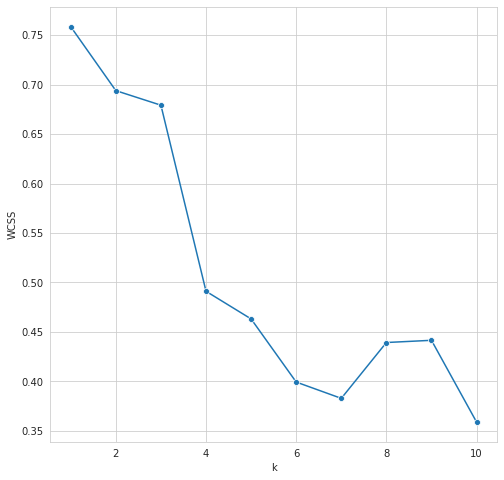

In [ ]:
sns.lineplot(x=range(1,11), y=cost_list, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Making the clusters

n_centroids = 1000
centroids = np.random.rand(n_centroids, 4) #n_centroids, number of centroids.
cluster_sizes = np.random.randint(1, 1000, size=n_centroids)
# labels from 1 to n_centroids inclusive
labels = np.repeat(np.arange(n_centroids), cluster_sizes) + 1
points = np.zeros((cluster_sizes.sum(), 2))
points[:,0] = np.repeat(centroids[:,0], cluster_sizes)
points[:,1] = np.repeat(centroids[:,1], cluster_sizes)
points += 0.05 * np.random.randn(cluster_sizes.sum(), 2)

In [ ]:
def diameter(pts):
  # need at least 3 points to construct the convex hull
  if pts.shape[0] <= 1:
    return 0
  if pts.shape[0] == 2:
    return ((pts[0] - pts[1])**2).sum()
  # two points which are fruthest apart will occur as vertices of the convex hull
  hull = spatial.ConvexHull(pts)
  candidates = pts[spatial.ConvexHull(pts).vertices]
  return spatial.distance_matrix(candidates, candidates).max()


In [ ]:
from scipy import spatial

def dunn_index(pts, labels, centroids):
  # O(k n log(n)) with k clusters and n points; better performance with more even clusters
  max_intracluster_dist = max(diameter(pts[labels==i]) for i in np.unique(labels))
  # O(k^2) with k clusters; can be reduced to O(k log(k))
  # get pairwise distances between centroids
  cluster_dmat = spatial.distance_matrix(centroids, centroids)
  # fill diagonal with +inf: ignore zero distance to self in "min" computation
  np.fill_diagonal(cluster_dmat, np.inf)
  min_intercluster_dist = cluster_sizes.min()
  return min_intercluster_dist / max_intracluster_dist


In [ ]:
%time dunn_index(points, labels, centroids)
# 2.2747798805721136 for 10 centroids.
# 2.2816365812808894 for 3 centroids.
# 2.205074497488054 for 2 centroids.
# 2.300749534146484 for 4 centroids.

CPU times: user 2.58 s, sys: 38.3 ms, total: 2.62 s
Wall time: 2.64 s


2.300749534146484

Making the cluster

In [ ]:
k = 3
centroids, cluster = kmeans(X, k)

In [ ]:
# Eucleadian distance measurement from data points closest to centroids
dist = np.linalg.norm(X - centroids[0,:],axis=1).reshape(-1,1)
dist[:10,:]

array([[0.84220602],
       [0.37451306],
       [0.33155428],
       [0.38733428],
       [0.62249255],
       [0.23090611],
       [0.20652928],
       [0.67081406],
       [0.41622321],
       [0.16776981]])

In [ ]:
import logging

def inertia(self, clusters):
        """
        Get the sum of squared distances of dataset points to their cluster centers for all clusters - defined as inertia
        :return: cluster_sum_of_squares_points_to_clusters
        """
        cluster_sum_of_squares_points_to_clusters = 0
        logging.debug("cluster points: {}".format(clusters))

        for centroid, cluster_points in clusters.items():
            logging.debug("the cluster has a centroid at: {}".format(centroid))

            logging.debug("calculate sum of squares from centroid to all points in that cluster...")
            for cluster_point in cluster_points:
                euclidean_norm_distance = self.get_euclidean_distance(cluster_point, centroid)
                euclidean_norm_distance_squared = euclidean_norm_distance**2
                logging.debug("squared euclidean dist from centroid {} to point {} is {}".format(centroid, cluster_point,
                                                                                                 euclidean_norm_distance_squared))
                cluster_sum_of_squares_points_to_clusters += euclidean_norm_distance_squared
        logging.info("inertia is: {}".format(cluster_sum_of_squares_points_to_clusters))
        return cluster_sum_of_squares_points_to_clusters


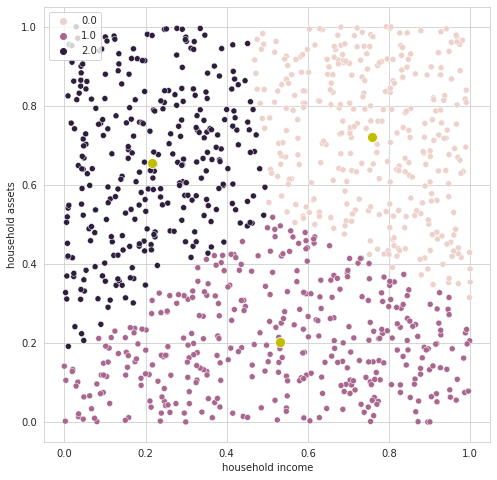

In [ ]:
sns.scatterplot(X[:, 0], X[:, 1], hue=cluster)
sns.scatterplot(centroids[:, 0], centroids[:, 1], s=100, color='y')
plt.xlabel('household income')
plt.ylabel('household assets')
plt.show()

Inertia

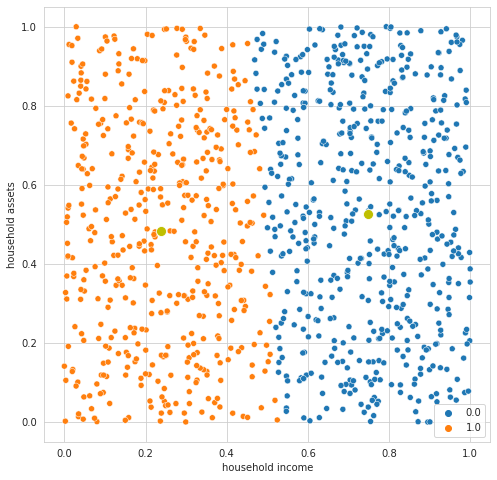

In [ ]:
k = 2
centroids, cluster = kmeans(X, k)
sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
plt.xlabel('household income')
plt.ylabel('household assets')
plt.show()

In [ ]:
dist = np.linalg.norm(X - centroids[0,:],axis=1).reshape(-1,1)
dist[:10,:]

array([[0.69113994],
       [0.25440255],
       [0.17892739],
       [0.36409612],
       [0.46076463],
       [0.42344176],
       [0.35279088],
       [0.69783586],
       [0.22495685],
       [0.35411263]])

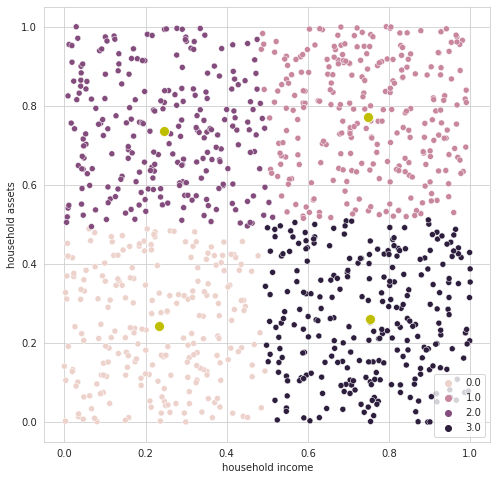

In [ ]:
k = 4
centroids, cluster = kmeans(X, k)
sns.scatterplot(X[:,0], X[:, 1], hue=cluster)
sns.scatterplot(centroids[:,0], centroids[:, 1], s=100, color='y')
plt.xlabel('household income')
plt.ylabel('household assets')
plt.show()

# IGNORE
Simply testing with SK learn to see if the results are ideal

In [ ]:
# Create cluster feature
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4) #number of clusters

X = df.loc[:, ["scaled_household_total_assets", "scaled_annual_household_income"]]
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,scaled_household_total_assets,scaled_annual_household_income,Cluster
0,0.246480,0.052374,3
1,0.977728,0.416263,1
2,0.888186,0.414998,1
3,0.391694,0.598363,0
4,0.436852,0.187984,3


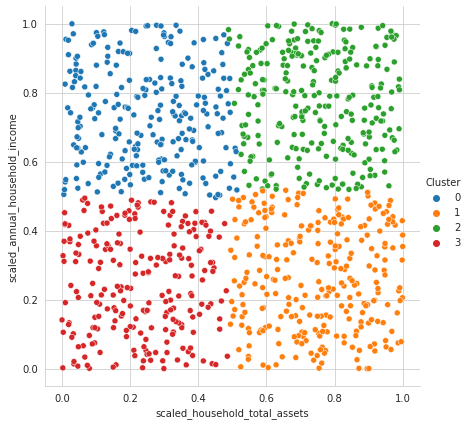

In [ ]:
sns.relplot(
    x="scaled_household_total_assets", y="scaled_annual_household_income", hue="Cluster", data=X, height=6,
);

In [ ]:
kmeans = KMeans(n_clusters=3) #number of clusters

X = df.loc[:, ["scaled_household_total_assets", "scaled_annual_household_income"]]
X["Cluster"] = kmeans.fit_predict(X)
X["Cluster"] = X["Cluster"].astype("category")

X.head()

,scaled_household_total_assets,scaled_annual_household_income,Cluster
0,0.246480,0.052374,1
1,0.977728,0.416263,0
2,0.888186,0.414998,0
3,0.391694,0.598363,1
4,0.436852,0.187984,0


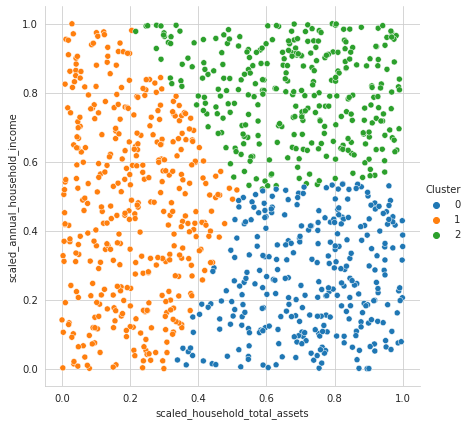

In [ ]:
sns.relplot(
    x="scaled_household_total_assets", y="scaled_annual_household_income", hue="Cluster", data=X, height=6,
);

Text(0.5, 1.0, 'Different Inertia Values for Different Number of Clusters')

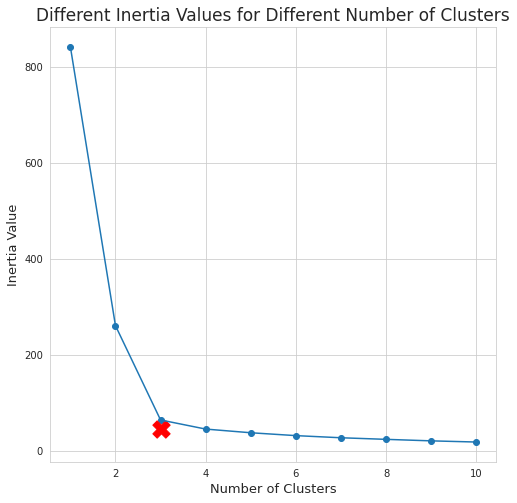

In [ ]:

%matplotlib inline
plt.rcParams['figure.figsize'] = [8,8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

inertia_list = []
for num_clusters in range(1, 11):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)
    
# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.scatter(3, inertia_list[3], marker="X", s=300, c="r")
plt.xlabel("Number of Clusters", size=13)
plt.ylabel("Inertia Value", size=13)
plt.title("Different Inertia Values for Different Number of Clusters", size=17)

In [ ]:
kmeans.inertia_

64.3548399375639

In [ ]:
print(inertia_list)

[842.1354238878585, 260.90991509986287, 64.3548399375639, 45.362815008817975, 37.687674572668314, 31.711030569729143, 27.257357297880013, 23.950850280801575, 20.809673237399767, 18.354668121738584]
